In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk

import yfinance as yf
import datetime




In [40]:
ticker='KCHOL.IS'
start="2021-01-01"
end=str(datetime.date.today() +datetime.timedelta(days=1))
kchol=yf.download(ticker,start,end)


[*********************100%***********************]  1 of 1 completed


In [41]:
kchol.index=pd.to_datetime(kchol.index)
kchol

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,21.120001,21.500000,21.040001,21.219999,19.642229,10353058
2021-01-05,21.000000,21.600000,20.860001,21.000000,19.438585,15345270
2021-01-06,21.240000,21.340000,20.860001,20.980000,19.420074,11481406
2021-01-07,21.200001,21.260000,20.879999,21.180000,19.605202,7609127
2021-01-08,21.219999,21.520000,21.120001,21.480000,19.882896,9849174
...,...,...,...,...,...,...
2023-06-14,99.949997,103.599998,98.300003,99.300003,99.300003,32298664
2023-06-15,99.800003,101.099998,98.849998,101.000000,101.000000,25989506
2023-06-16,101.300003,102.099998,99.400002,99.400002,99.400002,22481317


In [42]:
close=pd.DataFrame(kchol["Close"])

close


,Close
Date,
2021-01-04,21.219999
2021-01-05,21.000000
2021-01-06,20.980000
2021-01-07,21.180000
2021-01-08,21.480000
...,...
2023-06-14,99.300003
2023-06-15,101.000000
2023-06-16,99.400002


In [43]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=14).mean()
rolling_app21=close.rolling(window=21).mean()



In [44]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [46]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-02-01,20.440001,20.644000,21.535715,21.493334
2021-02-02,20.600000,20.468000,21.432858,21.463810
2021-02-03,21.440001,20.672001,21.384286,21.484762
2021-02-04,21.559999,20.848000,21.387143,21.512381
2021-02-05,21.260000,21.060000,21.331429,21.516191
...,...,...,...,...
2023-06-14,99.300003,100.820000,88.700001,85.285715
2023-06-15,101.000000,101.020000,90.696429,85.942858
2023-06-16,99.400002,100.860001,92.439286,86.871429


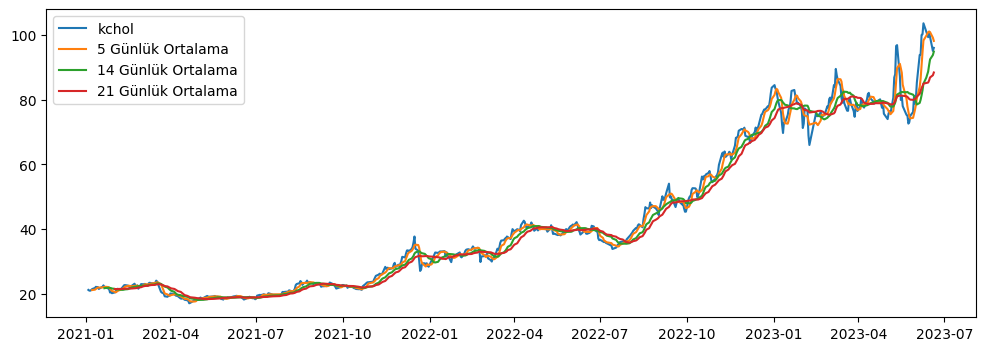

In [47]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='kchol')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='14 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='21 Günlük Ortalama')
ax.legend(loc='upper left')


In [48]:
def buy_sell_MA(data,opt=50):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    up=data[(np.array(data["short"]-data["mid"])>0) & (np.array(data["short"]-data["long"])>0)]
    down=data[(np.array(data["short"]-data["mid"])<0) & (np.array(data["short"]-data["long"])<0)]
    ups=np.percentile(np.array(up["short"]-up["mid"]),opt)
    downs=np.percentile(np.array(down["short"]-down["long"]),opt)


    for i in range(0,len(data)):
       if (data["short"][i]>data["mid"][i]+ups) & (data["short"][i]>data["long"][i]+ups):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
       elif(data["short"][i]<data["mid"][i]+downs)&(data["short"][i]<data["long"][i]+downs):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
       else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    
    PL=np.sum(operations)
    

    
    
    return (buy_signal,sell_signal,PL)





In [49]:
MAs["Buy"]=buy_sell_MA(MAs)[0]
MAs["Sell"]=buy_sell_MA(MAs)[1]

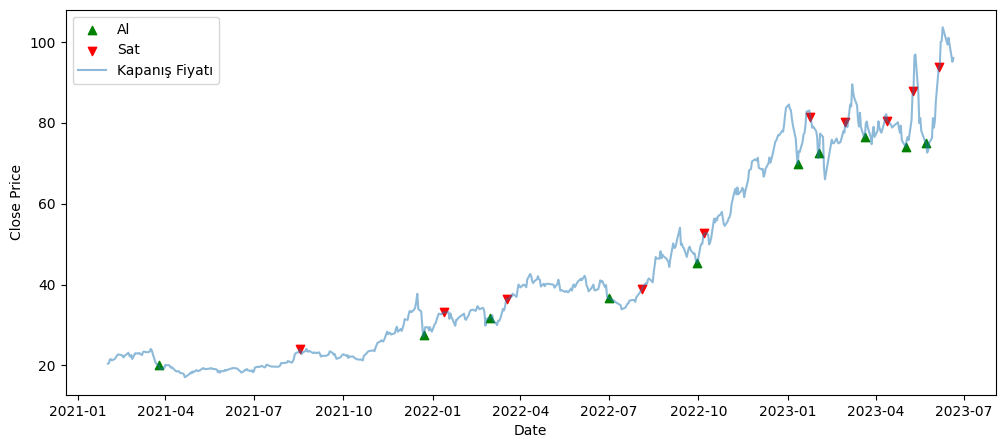

In [50]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

## Optimizing percentile variable to find best performance

In [51]:
def kar(percentile):
    MAs["Buy"]=buy_sell_MA(MAs,percentile)[0]
    MAs["Sell"]=buy_sell_MA(MAs,percentile)[1]
    al=MAs["Buy"]
    al=al.dropna(axis=0)
    sat=MAs["Sell"]
    sat=sat.dropna(axis=0)
    sat_val=sat.values
    al_val=al.values
    res=[]
    if len(al_val)==len(sat_val):
        for i in range(len(al_val)):
           res.append(sat_val[i]/al_val[i])
    elif len(al_val)>len(sat_val):
        al_val=np.delete(al_val,-1)
        for j in range(len(sat_val)):
           res.append(sat_val[j]/al_val[j])
    elif (len(sat_val)>len(al_val)):
        sat_val=np.delete(sat_val,0)
        for k in range(len(al_val)):
            res.append(sat_val[k]/al_val[k])
    
        

    
       

    

    df=pd.DataFrame()
    df["Kar"]=res

    return np.prod(df["Kar"])

In [52]:
MAs["Buy"]=buy_sell_MA(MAs,50)[0]
MAs["Sell"]=buy_sell_MA(MAs,50)[1]
al=MAs["Buy"]
al=al.dropna(axis=0)
sat=MAs["Sell"]
sat=sat.dropna(axis=0)
sat_val=sat.values
al_val=al.values

In [53]:
percentile=range(1,100)



In [54]:
kardf=pd.DataFrame()
kardf["Percentile"]=percentile

In [55]:

for i in range(len(percentile)):
  kardf.loc[i,1]=kar(percentile[i])

In [56]:
kardf.columns=["Percentile","Performance"]
kardf=kardf.sort_values(by="Performance",ascending=False)
kardf

,Percentile,Performance
93,94,8.769369
92,93,8.090756
94,95,7.173459
95,96,7.081124
90,91,6.733529
...,...,...
4,5,1.474047
3,4,1.474047
2,3,1.464967
1,2,1.464967


In [57]:
MAs["Buy"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[0]
MAs["Sell"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[1]

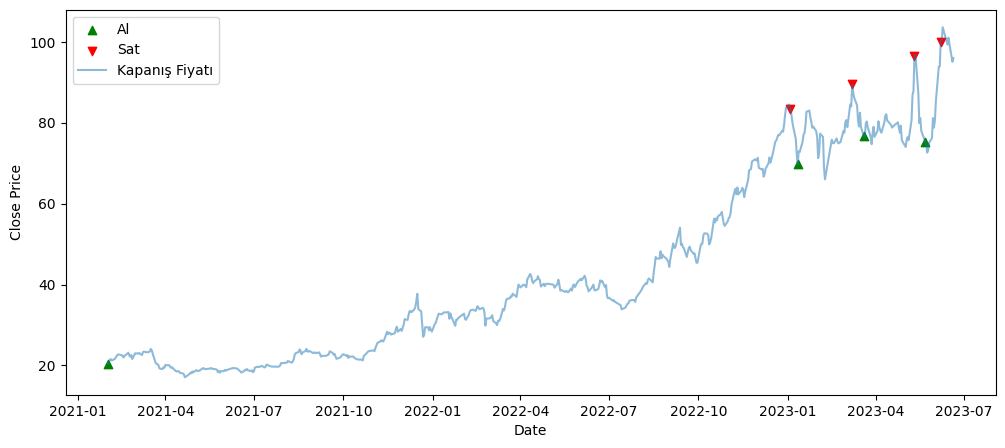

In [58]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [59]:
al=MAs["Buy"]
al=al.dropna(axis=0)
al

Date
2021-02-01    20.440001
2023-01-11    69.699997
2023-03-20    76.599998
2023-05-22    75.300003
Name: Buy, dtype: float64

In [60]:
sat=MAs["Sell"]
sat=sat.dropna(axis=0)
sat


Date
2023-01-03     83.349998
2023-03-08     89.500000
2023-05-11     96.599998
2023-06-07    100.000000
Name: Sell, dtype: float64

In [61]:
sat_val=sat.values
al_val=al.values


In [62]:
res=[]

for i in range(len(al_val)):
    res.append((sat_val[i]/al_val[i]))

In [63]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,4.077788
1,1.284075
2,1.261097
3,1.328021


In [65]:
res0=[100]
for i in range(len(df.index)):
    res0.append(res0[i]*df["Kar"].loc[i])

df["Eldeki Para"]=res0[1:]
df


,Kar,Eldeki Para
0,4.077788,407.778847
1,1.284075,523.618485
2,1.261097,660.333497
3,1.328021,876.936879


In [66]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 776.9368789611217
